In [17]:
%matplotlib notebook

In [6]:
import random
import numpy as np
import graph_tool as gt
from graph_tool import Graph, GraphView
from graph_tool.topology import random_spanning_tree
from graph_tool.generation import complete_graph, lattice
from graph_tool.draw import sfdp_layout, graph_draw

from tqdm import tqdm

from cascade_generator import si, observe_cascade
from graph_helpers import (extract_steiner_tree, filter_graph_by_edges, extract_edges,
                           extract_nodes, gen_random_spanning_tree, load_graph_by_name)
from viz_helpers import lattice_node_pos

In [29]:
random.seed(1234)
np.random.seed(1234)
shape = (10, 10)
graph_name = 'dolphin'
g = load_graph_by_name(graph_name)


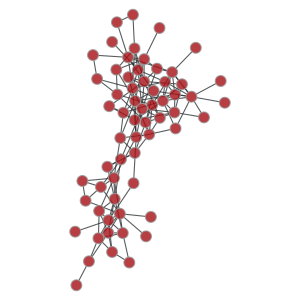

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f6d416e5438, at 0x7f6d416e5dd8>

In [30]:
if graph_name == 'lattice':
    pos = lattice_node_pos(g, shape)
else:
    pos = sfdp_layout(g)
graph_draw(g, pos=pos, output_size=(300, 300))    

In [11]:
s, c, t = si(g, 0.1)
o = observe_cascade(c, s, 0.2)
print(o)

[18 33  2 15]


In [31]:
sample_count = 500
steiner_trees_1 = []
for _ in tqdm(range(sample_count)):
    rand_t = gen_random_spanning_tree(g)
    st = extract_steiner_tree(rand_t, o)
    steiner_trees_1.append(st)

100%|██████████| 500/500 [00:09<00:00, 56.72it/s]


In [32]:
from core import det_score_of_steiner_tree
det_scores = [det_score_of_steiner_tree(st, g) for st in tqdm(steiner_trees_1)]

100%|██████████| 500/500 [00:19<00:00, 25.25it/s]


In [33]:
real_scores = np.exp([-st.num_edges() for st in steiner_trees_1])

<IPython.core.display.Javascript object>


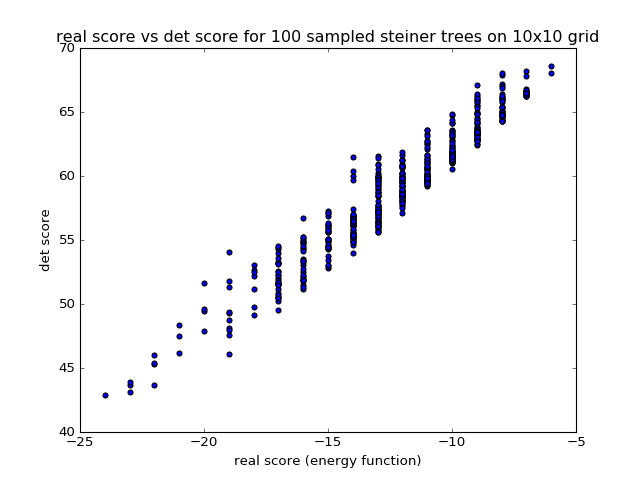

In [34]:
from matplotlib import pyplot as plt
plt.figure()
plt.scatter(np.log(real_scores), np.log(det_scores))
plt.xlabel('real score (energy function)')
plt.ylabel('det score')
plt.title('real score vs det score for 100 sampled steiner trees on 10x10 grid')

<IPython.core.display.Javascript object>


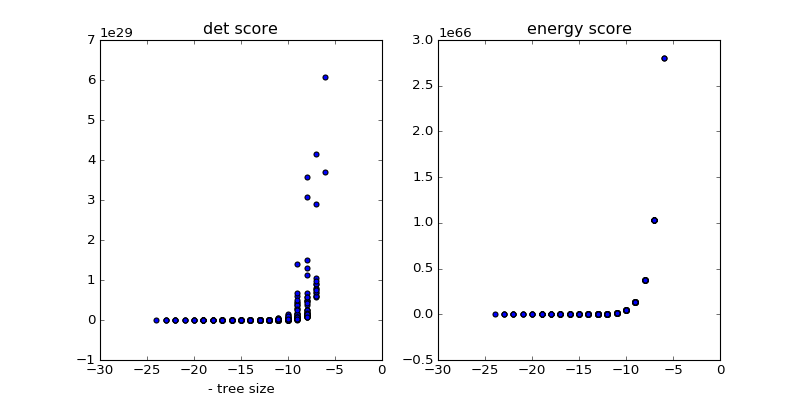

In [36]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

neg_tree_sizes = np.log(real_scores) 
energy_scores = np.exp(g.num_edges() + neg_tree_sizes)
ax[0].scatter(neg_tree_sizes, det_scores)
ax[0].set_xlabel('- tree size')
ax[1].scatter(neg_tree_sizes, energy_scores)
ax[0].set_title('det score')
ax[1].set_title('energy score')
# ax[9].xlabel('real score (energy function)')
# plt.ylabel('det score')
# plt.title('real score vs det score for 100 sampled steiner trees on 10x10 grid')

<IPython.core.display.Javascript object>


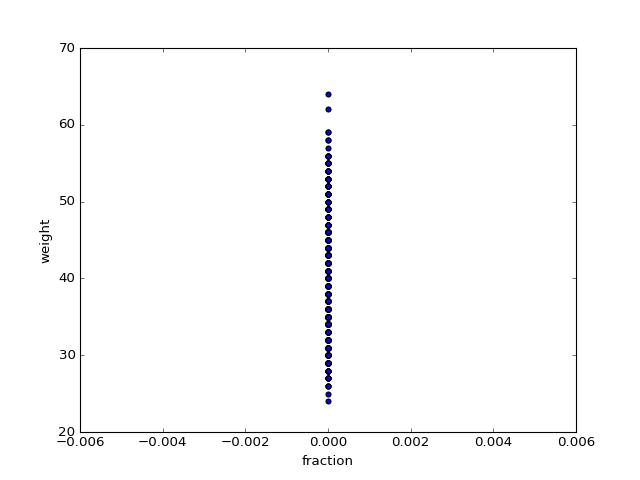

In [16]:
plt.figure()
plt.scatter(sampling_importance, -np.log(real_scores))
plt.xlabel('fraction')
plt.ylabel('weight')

In [15]:
sampling_importance = real_scores / np.array(det_scores)


In [13]:
sampling_importance = real_scores / np.array(det_scores)
print(sampling_importance[:10])
sampling_importance /= sampling_importance.sum()
print(sampling_importance)

[  4.58500591e-48   2.25221066e-46   8.88545528e-47   4.16501537e-47
   4.90178282e-46   4.39704194e-47   4.69005800e-46   1.55183548e-47
   4.52051181e-47   2.54564579e-47]
[  8.77761065e-05   4.31166909e-03   1.70104616e-03   7.97357386e-04
   9.38405357e-03   8.41776935e-04   8.97872411e-03   2.97085935e-04
   8.65414209e-04   4.87342614e-04   9.24064148e-04   2.28029119e-03
   1.74026986e-04   2.88849608e-03   8.56291911e-03   1.65242264e-03
   2.70947622e-03   1.84465108e-03   1.88069297e-04   6.32237116e-05
   2.63027212e-03   3.87411817e-04   3.06243033e-04   4.36485378e-03
   2.83288046e-03   1.28871116e-04   1.93527542e-03   1.87788163e-04
   4.48976524e-04   9.43315765e-04   9.55457688e-04   1.02157249e-03
   1.10379520e-03   6.53022204e-04   1.85606566e-04   4.30102006e-03
   1.28092526e-03   6.72439759e-04   2.26289875e-03   9.38139796e-05
   1.40646756e-03   8.13214742e-04   4.42612964e-03   4.01505048e-03
   6.07214659e-03   2.80403486e-04   2.31056746e-03   6.11811057e-0

In [ ]:
from numpy import random
m = 100
resampled_ids = random.choice(np.arange(len(steiner_trees_1)), m, replace=False, p=sampling_importance)


In [ ]:
c = np.zeros(len(steiner_trees_1))
c[resampled_ids] = 1

In [ ]:
sizes = np.array([st.num_edges() for st in steiner_trees_1])
plt.figure()
plt.clf()
x = sizes + random.rand(len(steiner_trees_1)) * 2
y = sizes + random.rand(len(steiner_trees_1)) * 2
plt.scatter(x, y, c=c, s=50, cmap='PiYG', alpha=0.5)
plt.xlabel('steiner tree size')
plt.ylabel('steiner tree size')
plt.title('green dots are selected while red are not')

In [ ]:
steiner_tree_samples = [steiner_trees_1[i] for i in resampled_ids]

In [ ]:
def node_occurrence_freq(n, trees):
    yes = 1  # smoothing
    no = 1
    for t in trees:
        try:
            t.vertex(n)
            yes += 1
        except ValueError:
            no += 1
    return yes, no

In [ ]:
def entropy_uncertainty(n, trees):
    yes, no = node_occurrence_freq(n, trees)
    p = np.array([yes, no], dtype=np.float32)
    p /= p.sum()
    return entropy(p)
    

In [ ]:
def count_uncertainty(n, trees):
    yes, no = node_occurrence_freq(n, trees)
    return min(yes, no)

In [ ]:
non_obs_nodes = set(extract_nodes(g)) - set(o)

entropy_uncertainties = {n: entropy_uncertainty(n, steiner_tree_samples)
                         for n in non_obs_nodes}
count_uncertainties = {n: count_uncertainty(n, steiner_tree_samples)
                         for n in non_obs_nodes}


In [ ]:
vcolor = g.new_vertex_property('int')
vcolor.set_value(1)
for i in o:
    vcolor[i] = 2

In [ ]:
vsize = g.new_vertex_property('float')
vsize.set_value(10)
for n, uncert in entropy_uncertainties.items():
    vsize[n] = uncert * 20
graph_draw(g, pos=pos, output_size=(300, 300), vertex_size=vsize, vertex_fill_color=vcolor,
           output='figs/concept-proof-entropy.pdf')

In [ ]:
vsize = g.new_vertex_property('float')
vsize.set_value(10)
for n, uncert in count_uncertainties.items():
    vsize[n] = uncert/3
graph_draw(g, pos=pos, output_size=(300, 300), vertex_size=vsize, vertex_fill_color=vcolor, 
           output='figs/concept-proof-count.pdf')